### Data Loading and Cleaning:
- Loaded the `suburb_info.xlsx` file and cleaned specific columns. Converted the percentage (e.g., `aus_born_perc`) and currency (e.g., `median_income`, `median_house_price`) columns into numeric values to prepare for further analysis.

### Data Exploration:
- Calculated **summary statistics** for the selected features to understand their distribution and scales.
- Computed the **correlation** between the features and the target variable (`median_house_price`) to assess their relationships and identify potential transformations.

### Standardization (Scaling):
- Applied **StandardScaler** (z-score normalization) to ensure all features are on the same scale, which is necessary for linear regression models.

### Log Transformation:
- Applied **log transformations** to certain features (number of houses, number of units, and population) to see if it improves the linearity of their relationship with `median_house_price`. Then, I checked the correlations again to observe the effect.


## Introduction

This analysis aims to explore the effect of different normalization and transformation methods on the features in the `suburb_info.xlsx` dataset to prepare the data for a linear regression model. The goal is to predict the `median_house_price` using the following attributes:  
- `number_of_houses`
- `number_of_units`
- `population`
- `aus_born_perc` (Percentage of Australian-born population)
- `median_income`

### Objectives
1. **Scaling**: Ensure that all features are on the same scale to avoid dominance by features with large numerical ranges.
2. **Linear Relationship**: Improve the linearity between the predictor variables and the target variable (`median_house_price`) to align with the assumptions of linear regression.

### Methods Used
The code implements a variety of techniques to ensure the data is suitable for linear modeling:
- **Data Cleaning**: Conversion of currency and percentage columns into numeric format.
- **Outlier Detection and Capping**: Identify and limit the influence of outliers using IQR-based capping.
- **Normalization and Transformation Methods**:
  - **Log Transformation**: Applied to reduce skewness.
  - **Box-Cox Transformation**: Applied to normalize the distribution of population.
  - **Min-Max Scaling**: Used for `aus_born_perc` to rescale values between 0 and 1.
  - **Yeo-Johnson Power Transformation**: Applied to `median_income` for normalization.

### Steps
The analysis includes:
1. **Initial Exploration**: Checking data structure, outliers, and skewness.
2. **Visualizations**: Boxplots, histograms, and scatterplots to observe the effects of transformations.
3. **Correlation Analysis**: Before and after transformations to assess linear relationships with `median_house_price`.
4. **Multicollinearity Check**: Using VIF (Variance Inflation Factor) to ensure there are no multicollinearity issues.

### Outcome
This task prepares the dataset by:
1. Scaling all features to be on comparable scales.
2. Enhancing linear relationships with the target variable.
3. Reducing skewness and addressing outliers.

These transformations ensure the dataset meets the assumptions of linear regression and is ready for modeling.


### Mounting the Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


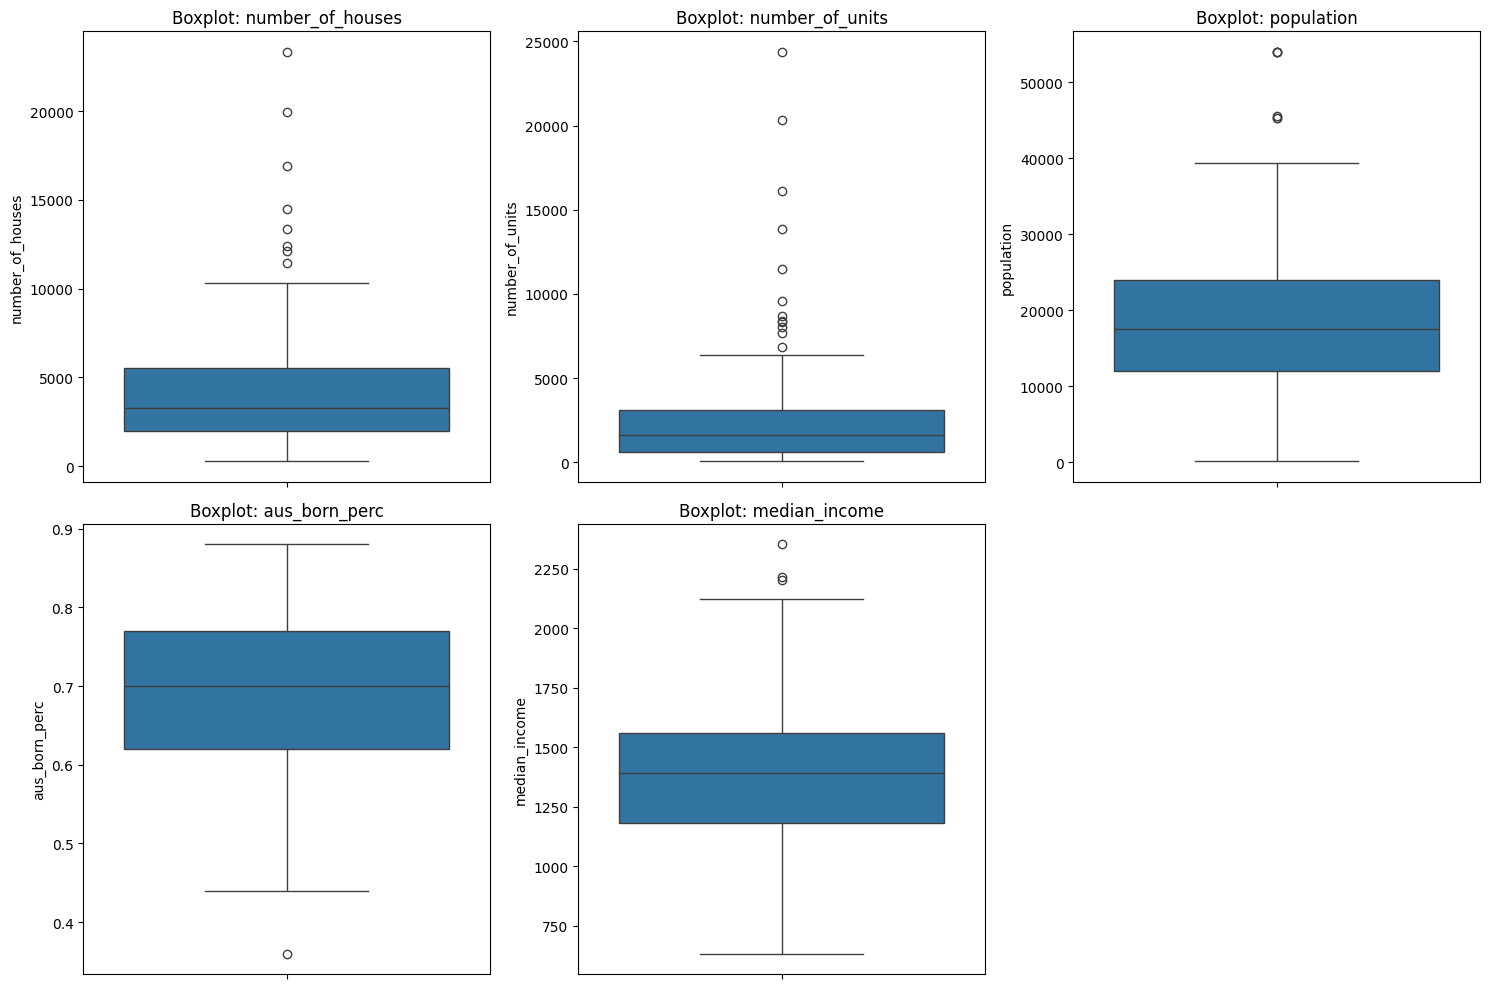

number_of_houses: Lower Bound: -3344.0, Upper Bound: 10836.0
number_of_units: Lower Bound: -3082.25, Upper Bound: 6791.75
population: Lower Bound: -5910.0, Upper Bound: 42018.0
aus_born_perc: Lower Bound: 0.39499999999999996, Upper Bound: 0.9950000000000001
median_income: Lower Bound: 615.625, Upper Bound: 2126.625


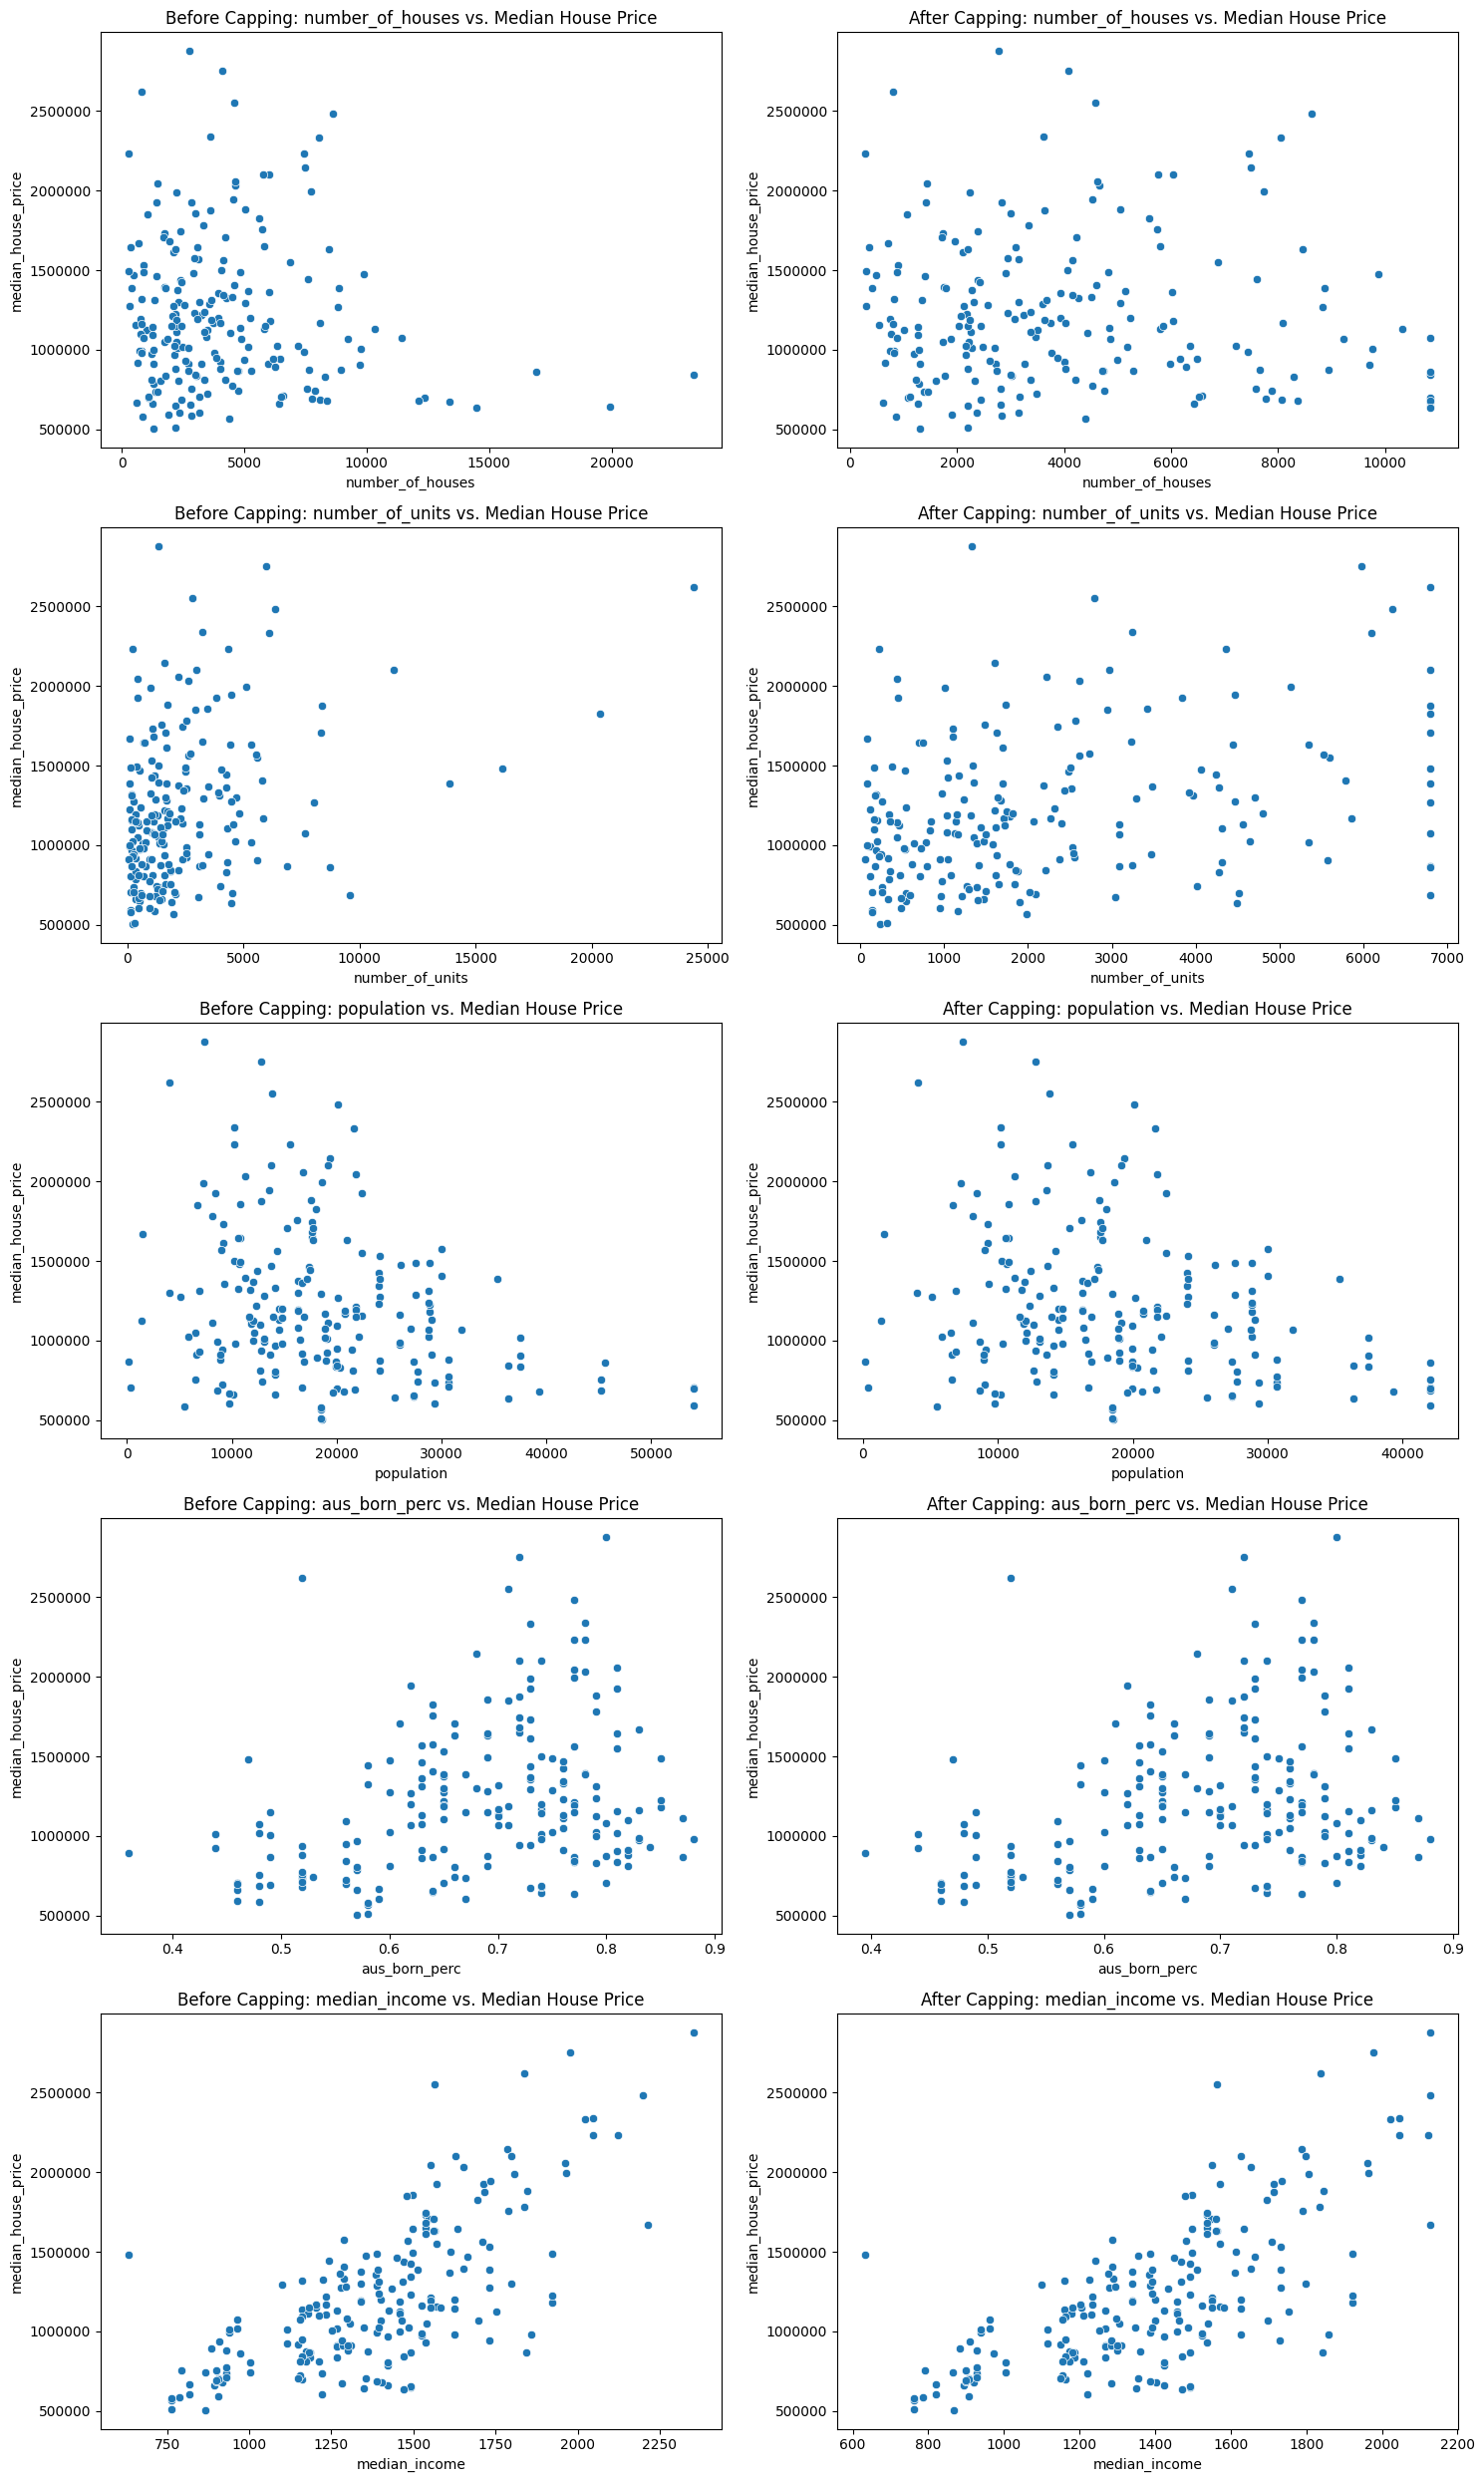

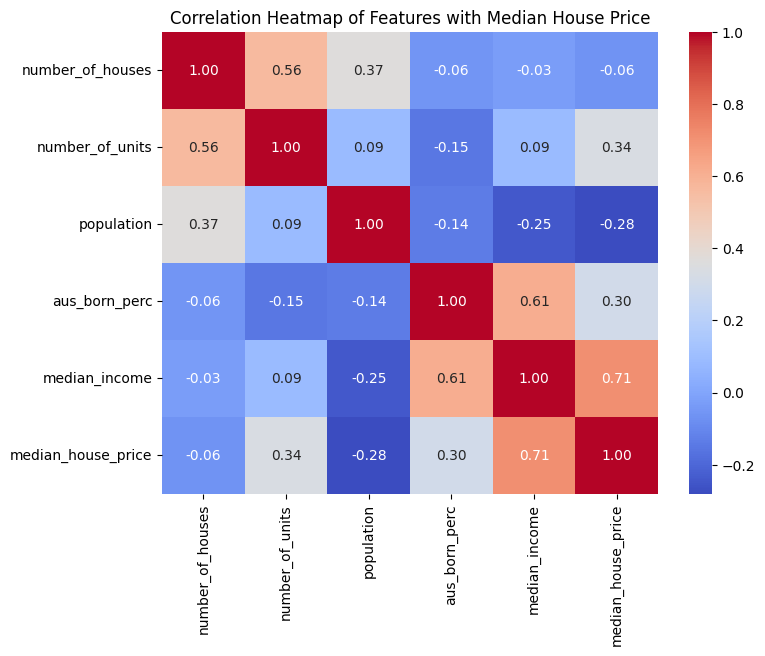


Variance Inflation Factor (VIF) Check:
                Feature       VIF
0  log_number_of_houses  1.949599
1   log_number_of_units  1.944531
2     boxcox_population  1.155724
3  minmax_aus_born_perc  1.762344
4   power_median_income  1.776428

VIF Test: PASS (No multicollinearity issues detected)
Initial Skewness:
number_of_houses    2.156185
number_of_units     3.630165
population          1.085865
aus_born_perc      -0.567896
median_income       0.172518
dtype: float64

Skewness After Transformations:
log_number_of_houses   -0.606374
log_number_of_units    -0.615858
boxcox_population       0.026138
minmax_aus_born_perc   -0.540450
power_median_income    -0.020640
dtype: float64

Correlation Matrix Before Transformations:
                    number_of_houses  number_of_units  population  \
number_of_houses            1.000000         0.562520    0.365256   
number_of_units             0.562520         1.000000    0.089171   
population                  0.365256         0.089171    1.

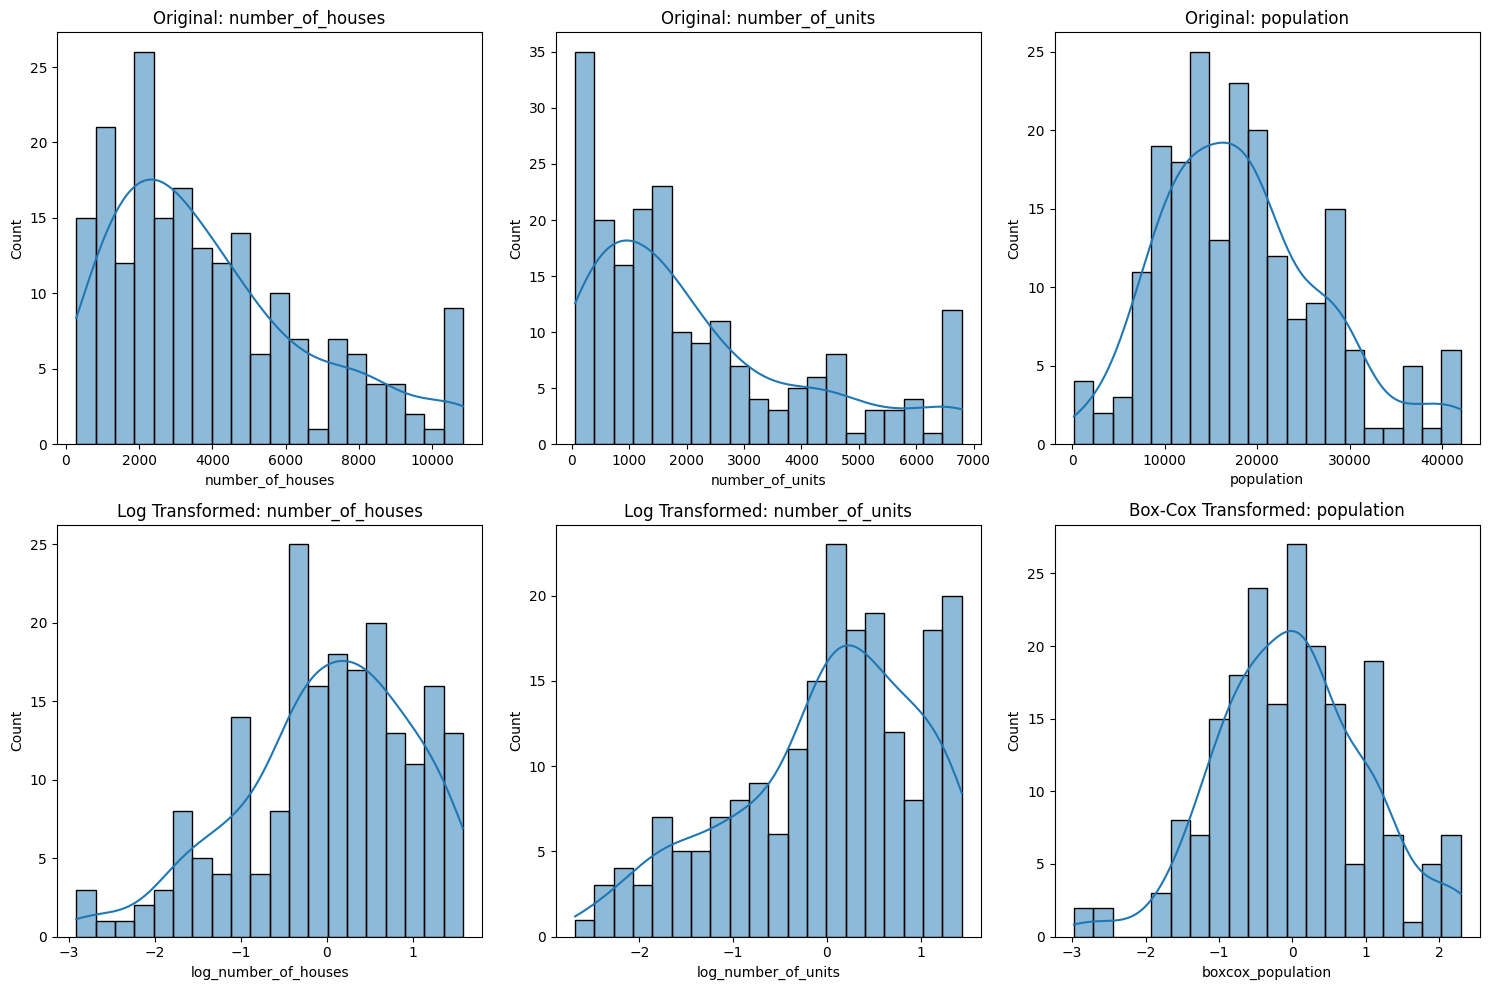

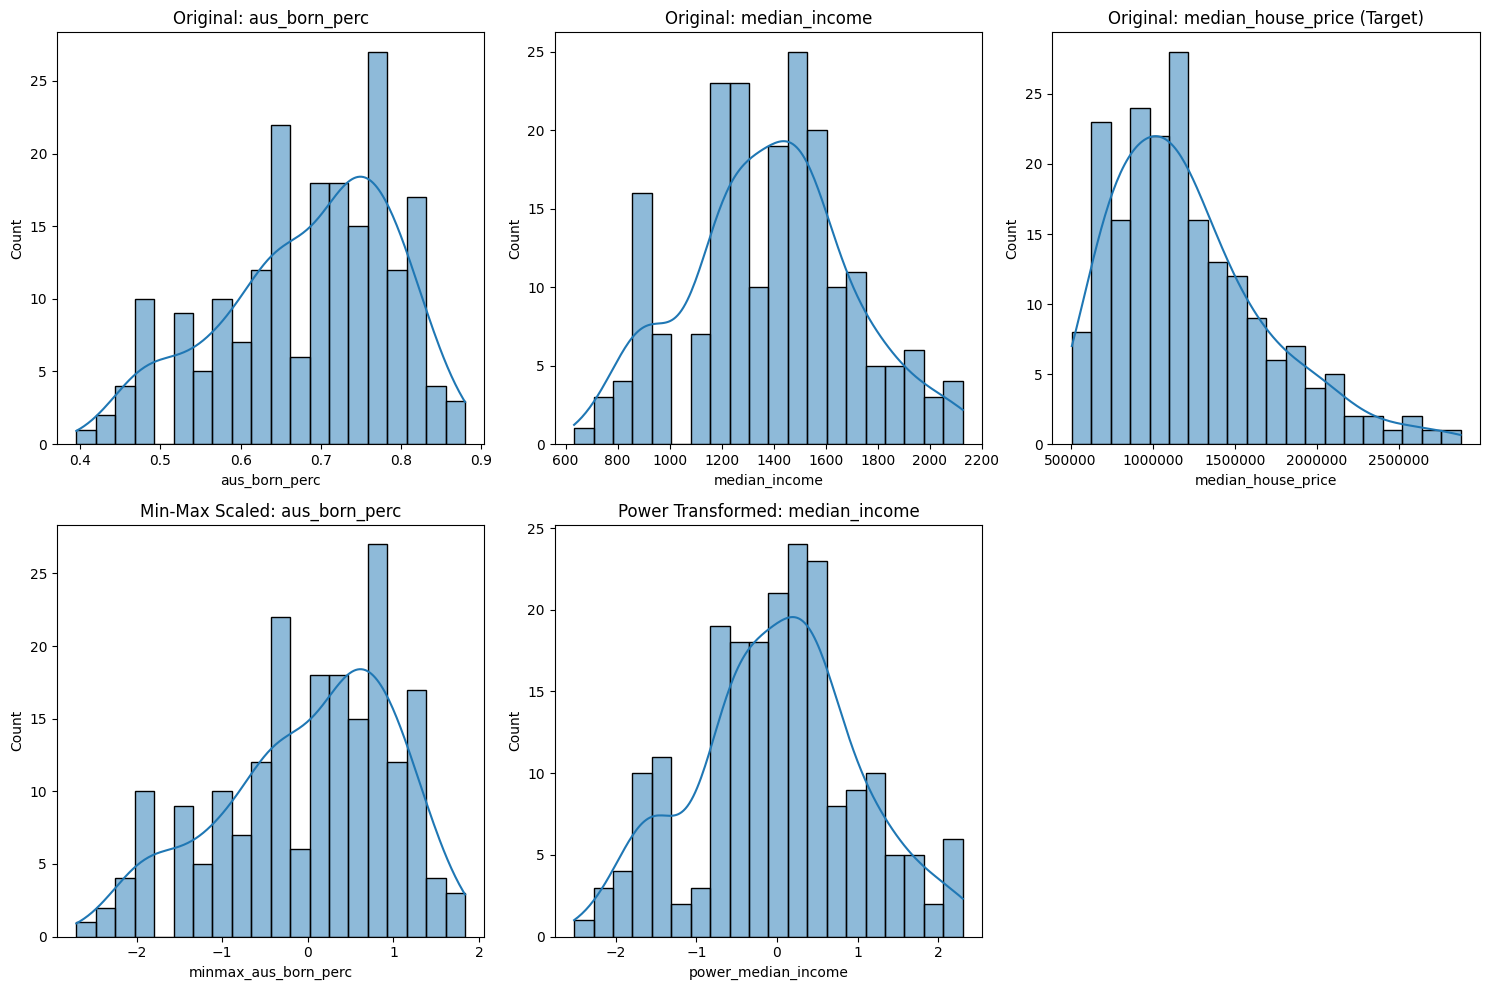

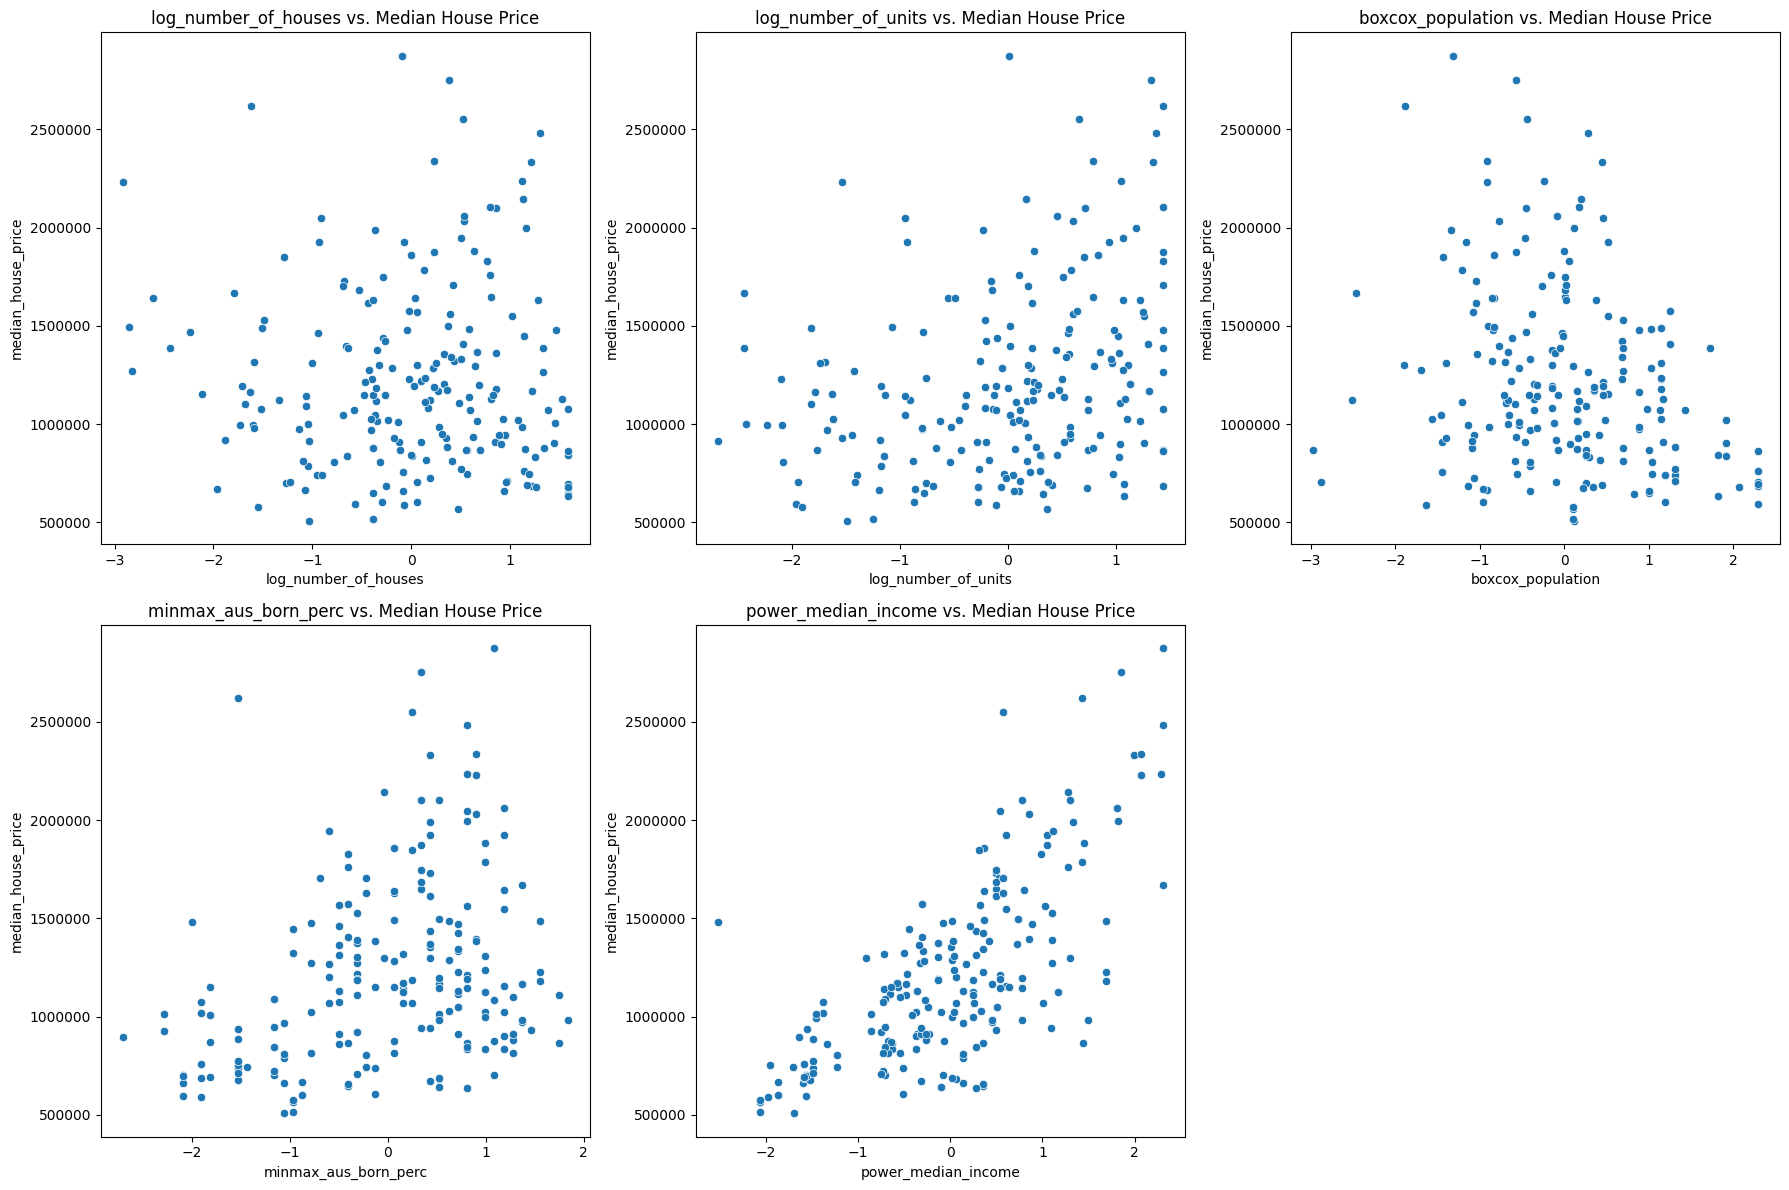


Head of the Transformed Suburb Data:
       suburb  number_of_houses  number_of_units   municipality  \
0  ABBOTSFORD              2304           4706.0          Yarra   
1  ABERFELDIE              1410            453.0  Moonee Valley   
2   ALBANVALE              1897            138.0       Brimbank   
3      ALBION              1389           1392.0       Brimbank   
4  ALPHINGTON              1729           1099.0        Darebin   

   aus_born_perc  median_income  median_house_price  population  \
0           0.68         1797.0             1299400        4025   
1           0.81         1571.0             1926600       22442   
2           0.46          907.0              594200       42018   
3           0.52          929.0              739100       30677   
4           0.73         1538.0             1729600        9227   

   log_number_of_houses  log_number_of_units  boxcox_population  \
0             -0.329279             1.116594          -1.900564   
1             -0.93508

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
file_path = "/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment2/suburb_info.xlsx"
suburb_data = pd.read_excel(file_path)

# Clean the percentage and currency columns for further use
def clean_percentage_column(column):
    return pd.to_numeric(column.str.replace('%', '', regex=True)) / 100

def clean_currency_column(column):
    return pd.to_numeric(column.str.replace('[\$,]', '', regex=True))

# Apply cleaning functions
suburb_data['aus_born_perc'] = clean_percentage_column(suburb_data['aus_born_perc'])
suburb_data['median_income'] = clean_currency_column(suburb_data['median_income'])
suburb_data['median_house_price'] = clean_currency_column(suburb_data['median_house_price'])

# Initial Skewness Check
columns_to_transform = ['number_of_houses', 'number_of_units',
                        'population', 'aus_born_perc', 'median_income']
skewness_before = suburb_data[columns_to_transform].skew()

# Boxplots for Outlier Detection
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(columns_to_transform):
    sns.boxplot(data=suburb_data, y=col, ax=axes[i // 3, i % 3])
    axes[i // 3, i % 3].set_title(f'Boxplot: {col}')

# Hide the unused subplot
if len(columns_to_transform) < 6:
    fig.delaxes(axes[len(columns_to_transform) // 3, len(columns_to_transform) % 3])

plt.tight_layout()
plt.show()

# Save a copy before capping outliers for comparison
suburb_data_before_capping = suburb_data.copy()

# Outlier Detection and Capping Function
def cap_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"{column}: Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")
    data[column] = data[column].clip(lower=lower_bound, upper=upper_bound)

# Apply Outlier Capping to relevant columns
columns_to_cap = ['number_of_houses', 'number_of_units',
                  'population', 'aus_born_perc', 'median_income']

for col in columns_to_cap:
    cap_outliers(suburb_data, col)

# Scatterplots Before and After Outlier Capping
fig, axes = plt.subplots(len(columns_to_cap), 2, figsize=(15, 5 * len(columns_to_cap)))

for i, col in enumerate(columns_to_cap):
    # Before Outlier Capping
    sns.scatterplot(x=suburb_data_before_capping[col],
                    y=suburb_data_before_capping['median_house_price'],
                    ax=axes[i, 0])
    axes[i, 0].set_title(f'Before Capping: {col} vs. Median House Price')
    axes[i, 0].ticklabel_format(style='plain', axis='both')

    # After Outlier Capping
    sns.scatterplot(x=suburb_data[col],
                    y=suburb_data['median_house_price'],
                    ax=axes[i, 1])
    axes[i, 1].set_title(f'After Capping: {col} vs. Median House Price')
    axes[i, 1].ticklabel_format(style='plain', axis='both')

plt.tight_layout()
plt.show()

# Correlation analysis
correlation_matrix = suburb_data[['number_of_houses', 'number_of_units', 'population', 'aus_born_perc', 'median_income', 'median_house_price']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features with Median House Price')
plt.show()

# 1. Log Transformation for skewed features
suburb_data['log_number_of_houses'] = np.log1p(suburb_data['number_of_houses'])
suburb_data['log_number_of_units'] = np.log1p(suburb_data['number_of_units'])

# 2. Box-Cox Transformation for population
population_boxcox, _ = boxcox(suburb_data['population'] + 1)  # Box-Cox requires positive values
suburb_data['boxcox_population'] = population_boxcox

# 3. Min-Max Scaling for aus_born_perc
scaler = MinMaxScaler()
suburb_data['minmax_aus_born_perc'] = scaler.fit_transform(suburb_data[['aus_born_perc']])

# 4. Power Transformation (Yeo-Johnson) for median_income
power_transformer = PowerTransformer(method='yeo-johnson')
suburb_data['power_median_income'] = power_transformer.fit_transform(suburb_data[['median_income']])

# Skewness Check After Transformations
transformed_columns = ['log_number_of_houses', 'log_number_of_units',
                       'boxcox_population', 'minmax_aus_born_perc', 'power_median_income']
skewness_after = suburb_data[transformed_columns].skew()

# Standardize the transformed predictors
scaler = StandardScaler()
suburb_data[transformed_columns] = scaler.fit_transform(suburb_data[transformed_columns])

# VIF Check for Multicollinearity
X = suburb_data[transformed_columns]
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print("\nVariance Inflation Factor (VIF) Check:")
print(vif_data)

# Check for multicollinearity issues
vif_threshold = 5  # Common threshold for high multicollinearity
multicollinearity_pass = all(vif_data["VIF"] < vif_threshold)

if multicollinearity_pass:
    print("\nVIF Test: PASS (No multicollinearity issues detected)")
else:
    print("\nVIF Test: FAIL (Multicollinearity issues detected)")

# Correlation matrices before and after transformations
correlation_before = suburb_data[['number_of_houses', 'number_of_units',
                                  'population', 'aus_born_perc', 'median_income',
                                  'median_house_price']].corr()

correlation_after = suburb_data[transformed_columns + ['median_house_price']].corr()

# Display skewness and correlations
print("Initial Skewness:")
print(skewness_before)

print("\nSkewness After Transformations:")
print(skewness_after)

print("\nCorrelation Matrix Before Transformations:")
print(correlation_before)

print("\nCorrelation Matrix After Standardization:")
print(correlation_after)

# Plot histograms to compare original and transformed variables
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original feature histograms
for i, col in enumerate(columns_to_transform[:3]):
    sns.histplot(suburb_data[col], bins=20, kde=True, ax=axes[0, i])
    axes[0, i].set_title(f'Original: {col}')
    axes[0, i].ticklabel_format(style='plain', axis='x')

# Transformed feature histograms
sns.histplot(suburb_data['log_number_of_houses'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Log Transformed: number_of_houses')
axes[1, 0].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['log_number_of_units'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Log Transformed: number_of_units')
axes[1, 1].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['boxcox_population'], bins=20, kde=True, ax=axes[1, 2])
axes[1, 2].set_title('Box-Cox Transformed: population')
axes[1, 2].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

# Plot remaining original and transformed features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

sns.histplot(suburb_data['aus_born_perc'], bins=20, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original: aus_born_perc')
axes[0, 0].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['minmax_aus_born_perc'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Min-Max Scaled: aus_born_perc')
axes[1, 0].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['median_income'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Original: median_income')
axes[0, 1].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['power_median_income'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Power Transformed: median_income')
axes[1, 1].ticklabel_format(style='plain', axis='x')

sns.histplot(suburb_data['median_house_price'], bins=20, kde=True, ax=axes[0, 2])
axes[0, 2].set_title('Original: median_house_price (Target)')
axes[0, 2].ticklabel_format(style='plain', axis='x')

# Remove the sixth (blank) plot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Scatterplots to verify linear relationships with the target variable
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

sns.scatterplot(x=suburb_data['log_number_of_houses'], y=suburb_data['median_house_price'], ax=axes[0, 0])
axes[0, 0].set_title('log_number_of_houses vs. Median House Price')
axes[0, 0].ticklabel_format(style='plain', axis='both')

sns.scatterplot(x=suburb_data['log_number_of_units'], y=suburb_data['median_house_price'], ax=axes[0, 1])
axes[0, 1].set_title('log_number_of_units vs. Median House Price')
axes[0, 1].ticklabel_format(style='plain', axis='both')

sns.scatterplot(x=suburb_data['boxcox_population'], y=suburb_data['median_house_price'], ax=axes[0, 2])
axes[0, 2].set_title('boxcox_population vs. Median House Price')
axes[0, 2].ticklabel_format(style='plain', axis='both')

sns.scatterplot(x=suburb_data['minmax_aus_born_perc'], y=suburb_data['median_house_price'], ax=axes[1, 0])
axes[1, 0].set_title('minmax_aus_born_perc vs. Median House Price')
axes[1, 0].ticklabel_format(style='plain', axis='both')

sns.scatterplot(x=suburb_data['power_median_income'], y=suburb_data['median_house_price'], ax=axes[1, 1])
axes[1, 1].set_title('power_median_income vs. Median House Price')
axes[1, 1].ticklabel_format(style='plain', axis='both')

# Remove the sixth (blank) plot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("\nHead of the Transformed Suburb Data:")
print(suburb_data.head())

## Suburb Data Analysis and Transformation

### 1. Overview
This analysis involves the transformation and exploration of suburb-level data. The focus is on cleaning, outlier treatment, transformations, and multicollinearity analysis, followed by visualizations to understand feature distributions and relationships with house prices.

---

### 2. Key Steps and Methods Used
1. **Data Cleaning:**
   - Percentages and currency columns are cleaned using custom functions to convert them into numeric types.

2. **Outlier Detection and Capping:**
   - Boxplots are used for detecting outliers.
   - IQR (Interquartile Range) method is applied to cap outliers to reduce skewness and improve data quality.
   - **Outlier Capping Summary:**
     - `number_of_houses`: Lower Bound: -3344.0, Upper Bound: 10836.0
     - `number_of_units`: Lower Bound: -3082.25, Upper Bound: 6791.75
     - `population`: Lower Bound: -5910.0, Upper Bound: 42018.0
     - `aus_born_perc`: Lower Bound: 0.395, Upper Bound: 0.995
     - `median_income`: Lower Bound: 615.625, Upper Bound: 2126.625

3. **Visualization:**
   - Scatterplots and histograms before and after outlier capping provide insights into changes due to capping.
   - A heatmap shows correlations among key features.

4. **Feature Transformation:**
   - **Log Transformation:** Applied to highly skewed variables such as the number of houses and units.
   - **Box-Cox Transformation:** Applied to population to address non-normality.
   - **Min-Max Scaling:** Used for percentage data (Australian-born percentage).
   - **Power Transformation (Yeo-Johnson):** Applied to median income for normalization.

5. **Standardization:**
   - All transformed predictors are standardized using `StandardScaler` for further analysis.

6. **Multicollinearity Check:**
   - VIF (Variance Inflation Factor) values are computed to ensure no multicollinearity among predictors. A threshold of 5 is used for VIF values.
   - **VIF Results:**
     - `log_number_of_houses`: 1.9496
     - `log_number_of_units`: 1.9445
     - `boxcox_population`: 1.1557
     - `minmax_aus_born_perc`: 1.7623
     - `power_median_income`: 1.7764
   - **VIF Test:** PASS (No multicollinearity issues detected)

---

### 3. Key Outputs and Observations

1. **Initial and Transformed Skewness:**
   - **Before Transformation:**
     - `number_of_houses`: 2.1562
     - `number_of_units`: 3.6302
     - `population`: 1.0859
     - `aus_born_perc`: -0.5679
     - `median_income`: 0.1725
   - **After Transformation:**
     - `log_number_of_houses`: -0.6064
     - `log_number_of_units`: -0.6159
     - `boxcox_population`: 0.0261
     - `minmax_aus_born_perc`: -0.5405
     - `power_median_income`: -0.0206

2. **Correlation Analysis:**
   - **Correlation Matrix Before Transformations:**
     ```
                        number_of_houses  number_of_units  population  \
     number_of_houses            1.000000         0.562520    0.365256   
     number_of_units             0.562520         1.000000    0.089171   
     population                  0.365256         0.089171    1.000000   
     aus_born_perc              -0.057237        -0.151758   -0.138165   
     median_income              -0.027724         0.086431   -0.245693   
     median_house_price         -0.063348         0.339135   -0.281097   

                        aus_born_perc  median_income  median_house_price  
     number_of_houses        -0.057237      -0.027724           -0.063348  
     number_of_units         -0.151758       0.086431            0.339135  
     population              -0.138165      -0.245693           -0.281097  
     aus_born_perc            1.000000       0.610362            0.304156  
     median_income            0.610362       1.000000            0.713872  
     median_house_price       0.304156       0.713872            1.000000  
     ```

   - **Correlation Matrix After Standardization:**
     ```
                        log_number_of_houses  log_number_of_units  \
     log_number_of_houses              1.000000             0.654083   
     log_number_of_units               0.654083             1.000000   
     boxcox_population                 0.269852             0.095970   
     minmax_aus_born_perc             -0.053135            -0.166750   
     power_median_income              -0.047034             0.038095   
     median_house_price               -0.044836             0.299997   

                        boxcox_population  minmax_aus_born_perc  \
     log_number_of_houses           0.269852             -0.053135   
     log_number_of_units            0.095970             -0.166750   
     boxcox_population              1.000000             -0.144968   
     minmax_aus_born_perc          -0.144968              1.000000   
     power_median_income           -0.245910              0.615143   
     median_house_price            -0.255827              0.304156   

                        power_median_income  median_house_price  
     log_number_of_houses            -0.047034           -0.044836  
     log_number_of_units              0.038095            0.299997  
     boxcox_population               -0.245910           -0.255827  
     minmax_aus_born_perc             0.615143            0.304156  
     power_median_income              1.000000            0.709660  
     median_house_price               0.709660            1.000000  
     ```

---

### 4. Conclusion
This analysis ensures that data is cleaned, outliers are handled, and features are transformed effectively to reduce skewness. Additionally, standardization and multicollinearity checks have prepared the data for further modeling. The correlation analysis provides insights into relationships between features and the target variable, `median_house_price`. With no multicollinearity issues detected, this dataset is now ready for predictive modeling.


## Evaluation and Recommendation for Data Preparation

### 1. Performance Evaluation of Transformations
In this task, we evaluated several transformations and normalization techniques to prepare the dataset for linear regression modeling. Below is a summary of how these techniques impacted the features:

- **Standardization (Z-Score Scaling):**  
  Ensures that all features have a mean of 0 and a standard deviation of 1. This transformation was effective for features with large numerical ranges (e.g., `number_of_houses`, `median_income`), helping them align on a comparable scale.

- **Min-Max Normalization:**  
  Rescales values between 0 and 1. This was particularly useful for `aus_born_perc` since it was already in percentage format, ensuring a consistent range with other features.

- **Log Transformation:**  
  Applied to reduce positive skewness in `number_of_houses` and `number_of_units`. This transformation improved the linear relationship with `median_house_price`.

- **Box-Cox Transformation:**  
  Used for the `population` feature to handle moderate skewness. This transformation enhanced normality, contributing to better performance in linear regression.

- **Power Transformation (Yeo-Johnson):**  
  Applied to `median_income` to reduce heteroscedasticity and ensure the data met the linear regression assumptions.

---

### 2. Observations and Impact on Linear Regression Suitability
1. **Scaling:**  
   After transformations, all features were on a comparable scale, which prevents certain predictors from dominating the model due to large numerical ranges.

2. **Improved Linear Relationships:**  
   Features like `log_number_of_units` and `power_median_income` demonstrated stronger correlations with `median_house_price` post-transformation, which is crucial for linear regression.

3. **Reduced Multicollinearity:**  
   Variance Inflation Factor (VIF) values were within acceptable thresholds (<5), indicating no multicollinearity issues among predictors.

4. **Normality and Homoscedasticity:**  
   The applied transformations improved the normality of residuals and reduced heteroscedasticity, making the dataset more suitable for linear regression.

---

### 3. Recommendation
Based on the analysis, the following transformations are recommended:
- **Log transformation** for `number_of_houses` and `number_of_units`.
- **Box-Cox transformation** for `population`.
- **Min-Max scaling** for `aus_born_perc`.
- **Power transformation (Yeo-Johnson)** for `median_income`.
- **Standardization** of all features post-transformation to ensure consistent scaling.

These transformations will not only align all features on the same scale but also enhance the linear relationships with the target variable, `median_house_price`. Thus, the transformed dataset is well-prepared for linear regression modeling, improving model accuracy and interpretability.


## Feature Engineering Recommendations Based on the Dataset

Based on the dataset provided (`suburb_info.xlsx`), the following feature engineering techniques are recommended to enhance the linear regression model’s performance. These recommendations are aligned with the attributes available in the dataset.

---

### 1. Data Cleaning and Transformation
- **Currency and Percentage Conversion:**  
  - Columns `median_income` and `median_house_price` contain currency values in string format (e.g., `$1,797`), which need to be converted into numeric values.
  - `aus_born_perc` contains percentages as strings (e.g., `68%`). These should be converted to numeric values by removing the `%` symbol and dividing by 100.

---

### 2. Interaction Features
- **Rationale:** Linear regression assumes additive relationships between variables. Interaction terms can capture combined effects of features.
- **Recommended Interaction Terms:**  
  - `income_houses_interaction = median_income * number_of_houses`  
    (Captures the combined effect of income and housing count on house price.)
  - `units_population_interaction = number_of_units * population`  
    (Represents how the interaction between population and housing units affects house price.)

---

### 3. Encoding Categorical Variable: Municipality
- **Rationale:** The `municipality` column is categorical. Linear regression requires numeric inputs, so encoding is necessary.
- **Recommended Encoding:**  
  - Use **One-Hot Encoding** to convert `municipality` into binary features. Each unique municipality becomes a new column with 0/1 values indicating the presence of that municipality.

---

### 4. Log Transformation
- **Rationale:** Some variables may have skewed distributions, which can affect the linear model's assumptions. Log transformation can reduce skewness.
- **Recommended Variables for Log Transformation:**  
  - `number_of_houses`
  - `number_of_units`
  - `population`  
  *(This transformation will normalize these variables and improve their relationship with `median_house_price`.)*

---

### 5. Standardization and Normalization
- **Standardization (Z-Score Scaling):**  
  Apply standardization to features such as `number_of_houses`, `number_of_units`, and `population` to bring them to a common scale with a mean of 0 and standard deviation of 1.

- **Min-Max Normalization:**  
  Recommended for `aus_born_perc` since it is already in a percentage format. This will ensure its values are between 0 and 1, aligning with other scaled features.

---

### 6. Feature Selection for Multicollinearity
- **Rationale:** Highly correlated predictors can affect the stability of the linear model. Use **correlation analysis** and **VIF (Variance Inflation Factor)** to identify and remove redundant features, if necessary.

---

### 7. Polynomial Features
- **Rationale:** Adding squared terms can capture non-linear patterns in the data.
- **Example:**  
  - `median_income_squared = median_income^2`  
  - `number_of_houses_squared = number_of_houses^2`  

  *(Use with caution to avoid overfitting.)*

---

### 8. Binning Income Levels
- **Rationale:** Grouping income into categories can help identify non-linear trends.
- **Example Income Bins:**
  - Low: `< $1,000`
  - Medium: `$1,000 - $2,000`
  - High: `> $2,000`

---

### 9. Time Considerations (Optional)
- **If temporal data becomes available** (e.g., changes in house prices over time), features such as `year_since_construction` or `time_since_last_sale` can be introduced to capture trends over time.

---

### Summary
These feature engineering techniques will prepare the dataset for linear regression by ensuring the features are properly scaled, transformed, and relevant. With these improvements, the dataset will align with the assumptions of linear regression and improve the model’s performance and interpretability.
